In [1]:
from useful_functions import *

gzip was not found on your system! You should solve this issue for astroquery.eso to be at its best!
On POSIX system: make sure gzip is installed and in your path!On Windows: same for 7-zip (http://www.7-zip.org)!


In [2]:
tess_2020bpi = pd.read_csv('JhaData/TESS_SN2020bpi.csv')[::2]
tess_2020bpi['mjd_0'] = tess_2020bpi['mjd'] - tess_2020bpi['mjd'].min()
tess_2020bpi.head()

,BTJD,mjd,cts,e_cts,bkg_model,raw_flux,e_raw_flux,bkg_model_flux,flux,e_flux,mjd_0
0,1870.44408,58869.94408,-5339.0302,1368.8706,1502.1435,-0.030663,0.007862,0.008627,0.001725,0.007501,0.00000
2,1870.46491,58869.96491,-6841.1413,1375.3282,1502.1435,-0.039290,0.007899,0.008627,-0.006505,0.007536,0.02083
4,1870.48574,58869.98574,-2219.7583,1400.7610,1501.2344,-0.012748,0.008045,0.008622,0.018823,0.007675,0.04166
6,1870.50658,58870.00658,-10843.6913,1370.6601,1501.2344,-0.062277,0.007872,0.008622,-0.028431,0.007510,0.06250
8,1870.52741,58870.02741,-9069.4821,1365.9754,1501.2344,-0.052088,0.007845,0.008622,-0.018710,0.007485,0.08333


In [3]:
ztf_2020bpi = pd.read_csv('JhaData/ztf_SN2020bpi.csv')
ztf_2020bpi['mjd_0'] = ztf_2020bpi['mjd'] - tess_2020bpi['mjd'].min() #ztf_2020bpi['mjd'].min()
ztf_2020bpi.head()

,BTJD,mjd,magap,sig_magap,flux,e_flux,mjd_0
0,1879.870567,58879.370567,19.729799,0.2218,0.014224,"(0.002628163767600394, 0.003223832161130714)",9.426487
1,1881.011065,58880.511065,19.959801,0.2436,0.011509,"(0.0023129338055085068, 0.0028946976073013723)",10.566985
2,1881.031343,58880.531343,19.473101,0.1538,0.018018,"(0.0023797689104727814, 0.002741920034638759)",10.587263
3,1881.843854,58881.343854,19.660400,0.2291,0.015163,"(0.0028844699689605166, 0.003562099310207071)",11.399774
4,1882.032546,58881.532546,19.363001,0.1425,0.019941,"(0.00245268546717093, 0.0027966740782900297)",11.588466


In [37]:
import emcee
import corner
from multiprocessing import Pool

def get_fullparam(t0=5,a=20,sigma=0,power=2):
    #nparam = len(theta)
    
    # 0th parameter is time of explosion t0
    # 1st parameter is a
    # 2nd parameter is sigma 
    # 3rd parameter is power, this is left out for now
    ## To Do: Make this use kwargs with dict so only specific 

    #assert (nparam >= 2) and (nparam <= 5), "invalid nparam"
    
    return {'t0':t0,'a':a, 'sigma':sigma, 'power':power}
    #     if nparam == 2:
    #         t0, a = theta
    #         sigma = 0.
    #         return t0, a, sigma
    #         # power = 2.
    #     elif nparam == 3:
    #         t0, a, sigma = theta
    #         return t0, a, sigma ## Fix, return in all cases
    #         # power = 2.
    #     elif nparam == 4:
    #         t0, a, sigma, power = theta
    #         return t0, a, sigma, power

def log_prior(theta):
    
    nparam = len(theta)
    thetaDict = get_fullparam(theta)
    
    logpr = 0.

#     if nparam <= 2:
#         return logpr

    if thetaDict['sigma'] <= 0:
        return -np.inf
    
    if thetaDict['t0'] < 0:
        return -np.inf
    
    if thetaDict['t0'] > 10:
        return -(10)**t0
    
    if thetaDict['a'] <= 0 or thetaDict['a'] >1000:
        return -np.inf
    
    
#     if power < 1.5 or power >2.5:
#         return -np.inf
      
    # Can play around with different priors if you want to    
    # if nparam >= 4:
    #     logpr -= np.log(sigma)

    return logpr

def log_likelihood(theta, data):
    
    thetaDict = get_fullparam(theta)
    
    var = (data['e_flux']**2 + thetaDict['sigma']**2)
    model = [0 if t <= thetaDict['t0'] else
             thetaDict['a'] * (t - thetaDict['t0'])**thetaDict['power'] 
             for t in data['mjd_0']]
    
    
    logl = -0.5 * (np.sum(np.log(2 * np.pi * var) + 
                            ((data['flux'] - model)**2 / var) ))
        
    return logl

    
def log_posterior(theta, data):
    
    logpr = log_prior(theta)
    
    if logpr == -np.inf:
        return logpr
    else:
        return logpr + log_likelihood(theta, data)

def doMCMC(data, guess, scale, nwalkers=100, nburn=1500, nsteps=3000):
    '''
    Takes data which contains mjd and flux data
    and performs an mcmc fit on it
    '''
    ndim = len(guess)
    assert ndim == len(scale)

    starting_guesses = np.swapaxes(list({
        k:(np.random.randn(nwalkers)*scale[k]+v)
        for k,v in guess.items()}.values()),0,1)

    print('sampling...')
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, threads=-1, args=[data])
    sampler.run_mcmc(starting_guesses, nsteps,progress=True)
    print('done')
    
    
    tlabels = [r"t0", 
           r"a",
           r"sigma",
            r"power"
           ]
    samples = sampler.chain[:, nburn:, :].reshape((-1, ndim))
    sampler.reset()

    figcorner = corner.corner(samples, labels=tlabels[0:ndim],
                    show_titles=True, title_fmt=".6f", verbose=True,
                    title_kwargs={"fontsize": 11}, label_kwargs={"fontsize": 14})

    return samples

0.21870047543581617

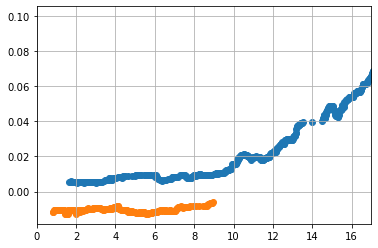

In [38]:
plt.scatter(tess_2020bpi[tess_2020bpi.flux >=0].mjd_0.rolling(48).median(),tess_2020bpi[tess_2020bpi.flux >=0].flux.rolling(48).median(),
           )
plt.scatter(tess_2020bpi[tess_2020bpi.flux <=0].mjd_0.rolling(48).median(),tess_2020bpi[tess_2020bpi.flux <=0].flux.rolling(48).median(),
           )
plt.xlim(0,17)
plt.grid()

len(tess_2020bpi[tess_2020bpi.flux <=0][tess_2020bpi.mjd_0 <28])/len(tess_2020bpi[tess_2020bpi.mjd_0 <28])

  0%|▎                                                                              | 20/5000 [00:00<00:25, 194.69it/s]

sampling...


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:25<00:00, 192.73it/s]


done


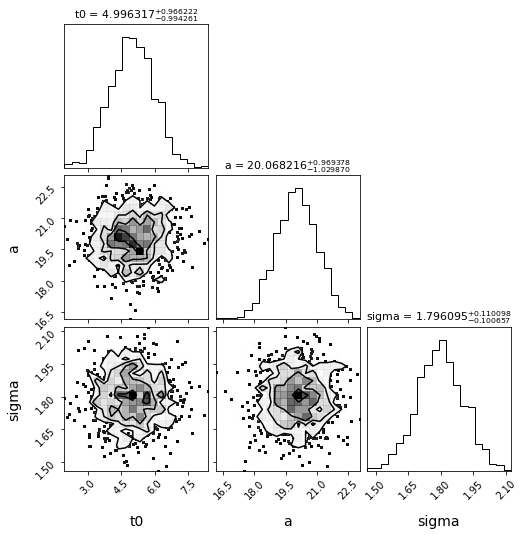

In [53]:
guess = {'t0':5, 'a':20,'power':1.8} ## t0, a, gamma, power
scale = {'t0':1, 'a':1,'power':0.1}
doMCMC(tess_2020bpi[tess_2020bpi.mjd_0 <= 16.75], guess, scale,nwalkers=1000,nburn=1500,nsteps=5000);
## t0 ~ 2 days if negative values excluded, t0 ~ 5.3 days if included 

In [ ]:
# tess_2020bpi[(tess_2020bpi.mjd_0 > 16.70) & (tess_2020bpi.mjd_0 <16.75)]['flux'].mean()/tess_2020bpi['flux'].max()
# tess_2020bpi[(tess_2020bpi.mjd_0 < 28)][(tess_2020bpi.flux > 0.397*tess_2020bpi.flux.max()) & 
#              (tess_2020bpi.flux < 0.402*tess_2020bpi.flux.max())]

In [ ]:
tess_2020bpi[(tess_2020bpi.mjd_0 > 16.66) & (tess_2020bpi.mjd_0 <16.67)]['flux'].mean()/tess_2020bpi['flux'].max()

In [ ]:
def get_fullparam_test(t0=5,a=20,sigma=0,power=2):

    #nparam = len(theta)
    
    # 0th parameter is time of explosion t0
    # 1st parameter is a
    # 2nd parameter is sigma 
    # 3rd parameter is power, this is left out for now
    ## To Do: Make this use kwargs with dict so only specific 

    #assert (nparam >= 2) and (nparam <= 5), "invalid nparam"
    
    return {'t0':t0,'a':a, 'sigma':sigma, 'power':power}

#     if nparam == 2:
#         t0, a = theta
#         sigma = 0.
#         return t0, a, sigma
#         # power = 2.
#     elif nparam == 3:
#         t0, a, sigma = theta
#         return t0, a, sigma ## Fix, return in all cases
#         # power = 2.
#     elif nparam == 4:
#         t0, a, sigma, power = theta
#         return t0, a, sigma, power

In [ ]:
get_fullparam_test(t0=0)

In [29]:
guess = {'t0':3, 'a':0.05} ## t0, a, gamma, power
scale = {'t0':0, 'a':0}
gArray = [3,0.05]
sArray = [0,0]
nwalkers = 50
starting_guesses = np.swapaxes(list({
        kg:(np.random.randn(nwalkers)*scale[kg]+vg)
        for kg,vg in guess.items()
    }.values()),0,1)
sgArray = np.random.randn(nwalkers, len(gArray))*sArray + gArray 
starting_guesses[0], sgArray[0]
starting_guesses.shape, sgArray.shape

((50, 2), (50, 2))

In [ ]:
[scale[kg] for kg,vg in guess.items()][0]

In [ ]:
[starting_guesses[key] for key in starting_guesses.keys()][0][0]